In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Importing the necessary libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

## Reading the training and testing datasets

In [3]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Cleaning the data

In [4]:
train.isna().sum().reset_index()

,index,0
0,Id,0
1,MSSubClass,0
2,MSZoning,0
3,LotFrontage,259
4,LotArea,0
...,...,...
76,MoSold,0
77,YrSold,0
78,SaleType,0
79,SaleCondition,0


### Combining train and test sets

In [5]:
target_price = train['SalePrice']
test_id = test['Id']
new_train = train.drop(['Id', 'SalePrice'], axis=1)
new_test = test.drop(['Id'], axis=1)
data = pd.concat([new_train, new_test], axis=0)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Fixing the datatypes

In [6]:
copy_data = data.copy()


### Filling categorical missing values

In [7]:
for column in ['Alley',
               'BsmtQual',
               'BsmtExposure', 
               'BsmtCond',
               'BsmtFinType1',
               'BsmtFinType2', 
               'FireplaceQu', 
              'GarageType',
               'GarageFinish',
               'GarageQual', 
              'GarageCond',
               'PoolQC', 
               'Fence', 
               'MiscFeature']:
    copy_data[column] = copy_data[column].fillna("None")
    
for column in ['MSZoning',
               'Utilities',
               'Exterior1st', 
               'Exterior2nd', 
               'MasVnrType',
             'Electrical', 
               'KitchenQual', 
               'Functional',
               'SaleType' ]:
    copy_data[column] = copy_data[column].fillna(copy_data[column].mode()[0])
    

In [8]:
copy_data.loc[:, copy_data.isna().sum()>0].columns
copy_data.select_dtypes('object').loc[:, copy_data.isna().sum()>0].columns

Index([], dtype='object')

In [9]:
copy_data.select_dtypes('object').isna().sum()
copy_data.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      486
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 79, dtype: int64

#### Filling missing values in numeric columns of data

In [10]:
copy_data.select_dtypes(np.number).loc[:, copy_data.isna().sum()>0].columns
for column in ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea']:
    copy_data[column] = copy_data[column].fillna(copy_data[column].mode()[0])

In [11]:
copy_data.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

In [12]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

### We have cleaned our dataset....yayyy!!

# Feature selection

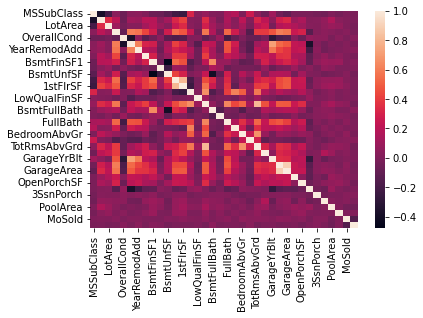

In [13]:
data_corr = copy_data.corr()
hm = sn.heatmap(data_corr)

In [14]:
copy_data['TotalSQFT'] = copy_data['TotalBsmtSF'] + copy_data['1stFlrSF'] + copy_data['2ndFlrSF']
copy_data['Yearbuilt/remodelled'] = copy_data['YearBuilt'] + copy_data['YearRemodAdd']
copy_data['BSMT'] = copy_data['1stFlrSF'] + copy_data['2ndFlrSF']
copy_data['TotalBathrooms'] = copy_data['FullBath'] + copy_data['HalfBath'] + copy_data['BsmtFullBath'] + copy_data['BsmtHalfBath']

In [15]:
copy_data['HasPool'] = copy_data['PoolArea'].apply(lambda x : 1 if x>0 else 0)
copy_data['Has2ndFloor'] = copy_data['2ndFlrSF'].apply(lambda x : 1 if x>0 else 0)
copy_data['HasGarage'] = copy_data['GarageArea'].apply(lambda x : 1 if x>0 else 0)
copy_data['HasBsmt'] = copy_data['TotalBsmtSF'].apply(lambda x : 1 if x>0 else 0)
copy_data['HasFireplace'] = copy_data['Fireplaces'].apply(lambda x : 1 if x>0 else 0)

In [16]:
copy_data.head()
final_features = pd.get_dummies(copy_data).reset_index()
final_features.head()

,index,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,1,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,2,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,3,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,4,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0


### Splitting the dataset for training/testing

In [17]:
x_train = final_features[:1460]
x_test = final_features[1460:]

## Principal component analysis (PCA)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)

In [19]:
from sklearn.decomposition import PCA
pca_com = 250
pca = PCA(n_components=312)
x_train = pca.fit_transform(x_train)

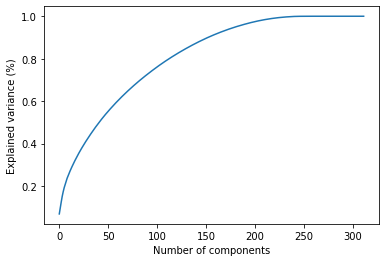

In [20]:
explained_variance = pca.explained_variance_ratio_
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.show()

### Dropping the redundant features

In [21]:
var_matrix = (pd.concat([pd.DataFrame(list(final_features.columns), columns = ['Factors']),
                         pd.DataFrame(list(explained_variance**2), columns = ['^2 variance'])], axis=1)).sort_values(by='^2 variance', ascending=False)[0:pca_com]

list(var_matrix['Factors'])

x_new = final_features[list(var_matrix['Factors'])]
x_new.shape
x_new.head()

,index,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev
0,0,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,1,0,0,0,0,0,0,0
1,1,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,0,0
2,2,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,1,0,0,0,0,0,0,0
3,3,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,1,0,0,0,0,0,0,0
4,4,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,1,0,0,0,0,0,0,0


### Resplitting the dataset into test and train

In [22]:
x_train = x_new[:1460]
x_test = x_new[1460:]

# Building a linear regression model

In [23]:
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(x_train, target_price, test_size=0.4)
x_shape = [x_train_t.shape, x_test_t.shape]
y_shape = [y_train_t.shape, y_test_t.shape]
print(x_shape)
print(y_shape)

[(876, 250), (584, 250)]
[(876,), (584,)]


### Training the model

In [24]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()

model = LR.fit(x_train_t, y_train_t)

### Running test cases

In [25]:
predicted_price = LR.predict(x_test_t)

### Comparison between test values and predicted values

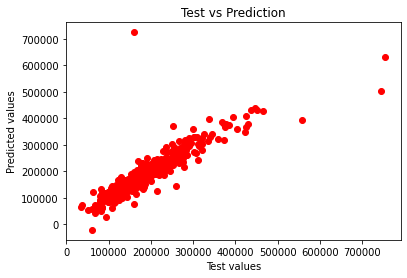

In [26]:
plt.scatter(y_test_t, predicted_price, color='r')
plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.title('Test vs Prediction')
plt.show()

# Final submission

In [27]:
y_pred = model.predict(x_test_t)
prediction = pd.DataFrame(y_pred)

prediction.columns = ['SalePrice']
id_data = pd.DataFrame(test['Id'])
prediction = pd.concat([id_data, prediction], axis=1)

prediction['SalePrice'] = prediction['SalePrice'].fillna(prediction['SalePrice'].mode()[1])

prediction['SalePrice'] = prediction['SalePrice'].astype(float)


In [28]:
prediction.to_csv('KaggleSubVideo.csv', index=False)

In [29]:
prediction

,Id,SalePrice
0,1461,206622.007946
1,1462,155685.106710
2,1463,89909.576467
3,1464,208744.159065
4,1465,265919.416527
...,...,...
1454,2915,27600.516979
1455,2916,27600.516979
1456,2917,27600.516979
1457,2918,27600.516979
